In [1]:
%load_ext autoreload
%autoreload 3
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [2]:
import os
import functools
import re
import pathlib

root = pathlib.Path(os.environ["DATA_ROOT"]).expanduser()

<IPython.core.display.Javascript object>

In [3]:
import numpy as np

# import numba as nb
import plotnine as p9
import pandas as pd

import seaborn as sns
from datetime import datetime


%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv(root / "ocr-output.csv").query("frame_num >= 16")

<IPython.core.display.Javascript object>

In [5]:
def make_monotonic(s, window_radius=11, threshold=1e-3):
    assert (
        s.index == np.arange(len(s))
    ).all(), "Series must begin with sorted default index."

    s_out = s.copy()

    s = s.dropna()
    diffs = s.diff()

    while (diffs < -threshold).any():
        # Find values on either side of the largest current negative diff.
        arg_min_diff = diffs.argmin()
        val_left = s.iloc[arg_min_diff - 1]
        val_right = s.iloc[arg_min_diff]

        # Decide whether we'll null out the left or the right value.
        window = s.iloc[
            max(0, arg_min_diff - window_radius) : min(
                len(s), arg_min_diff + window_radius
            )
        ]
        wmd = window.median()
        if abs(val_left - wmd) < abs(val_right - wmd):
            # Right is farther away, null it out.
            s.iloc[arg_min_diff] = np.nan
        else:
            # Null out left.
            s.iloc[arg_min_diff - 1] = np.nan

        s = s.dropna()
        diffs = s.diff()

    return s_out.combine(s, lambda a, b: b)


<IPython.core.display.Javascript object>

In [6]:
def _process_time_ppocr(s):
    try:
        if np.isnan(s):
            return None
    except TypeError:
        pass
    if len(s) < 5:
        return None
    s = s[-5:]
    a, m, b = s[:2], s[2], s[3:]
    if m != ":":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def _process_time_ssocr(s):
    s = s.strip("._")
    if len(s) != 5:
        return None
    a, m, b = s[:2], s[2], s[3:]
    if m != "1":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def process_time_ppocr(series):
    return series.apply(_process_time_ppocr)


def process_time_ssocr(series):
    return series.apply(_process_time_ssocr)


def _process_distance_ppocr(s):
    if not isinstance(s, str):
        return None
    # search for the pattern in the input string
    match = re.search(r"\b\d{1,2}\.\d{2}\b", s)
    # if a match is found, parse the matched substring as a float and return it
    if match:
        return float(match.group())
    # if no match is found, return None
    else:
        return None


def process_distance_ppocr(series):
    return series.apply(_process_distance_ppocr)


def make_it_float(s):
    return pd.to_numeric(s, errors="coerce")


def process_field(
    df,
    landmark,
    ppocr_fn=make_it_float,
    ssocr_fn=make_it_float,
    enforce_monotonicity=False,
    debug=False,
):
    _df = (
        df.query("landmark == @landmark")
        .reset_index(drop=True)
        .assign(
            _ppocr=lambda f: ppocr_fn(f.inference_text),
            _ssocr=lambda f: ssocr_fn(f.ssocr),
        )
        .assign(
            # Pre-null ssocrs where pp confidence is high.
            _ssocr=lambda f: f._ssocr.where(
                f.inference_score.isna() | (f.inference_score < 0.98), np.nan
            ),
            # Coalesce.
            _fused=lambda f: f._ppocr.combine_first(f._ssocr),
            # Identify sites where both ocrs have a value, and they agree.
            _both_defined_mask=lambda f: f._ppocr.notna() & f._ssocr.notna(),
            # _raw_disagree_mask=lambda f: ,
            _agree_mask=lambda f: f._ppocr == f._ssocr,
            _disagree_mask=lambda f: (f._ppocr != f._ssocr) & f._both_defined_mask,
            # Apply mask.
            fused=lambda f: f._fused.where(~f._disagree_mask, np.nan),
        )
    )

    if enforce_monotonicity:
        _df = _df.assign(fused=lambda f: make_monotonic(f.fused))

    if debug:
        return _df.rename(columns={"fused": landmark})

    return _df.loc[:, ["frame_num", "fused"]].rename(columns={"fused": landmark})

<IPython.core.display.Javascript object>

In [7]:
speed_df = process_field(df, "SPEED")
watts_df = process_field(df, "WATTS")
cadence_df = process_field(df, "CADENCE")
distance_df = process_field(
    df, "DISTANCE", ppocr_fn=process_distance_ppocr, enforce_monotonicity=True
)
time_df = process_field(
    df,
    "TIME",
    ppocr_fn=process_time_ppocr,
    ssocr_fn=process_time_ssocr,
    enforce_monotonicity=True,
)
calories_df = process_field(
    df,
    "CALORIES",
    enforce_monotonicity=True,
)


# p9.ggplot(calories_df, p9.aes("frame_num", "CALORIES")) + p9.geom_line()

<IPython.core.display.Javascript object>

In [8]:
tr_table = pd.read_csv("top-row-states.csv").rename(columns=str.upper)


def _impute(row, tr):
    indices = ["SPEED", "WATTS", "CADENCE"]

    vals = row.loc[indices]
    if vals.isna().all():
        return row

    # distances = np.sqrt((tr - vals) ** 2).mean(axis="columns")
    distances = (tr != vals).sum(axis="columns")

    min_idx = distances.idxmin()
    min_val = distances.loc[min_idx]

    if min_val <= 2:
        row.loc[indices] = tr.loc[min_idx]
        return row
    else:
        row.loc[indices] = np.nan
        return row


def impute_top_row(df, tr=tr_table):
    return df.apply(lambda e: _impute(e, tr), axis="columns")


toprow_df = impute_top_row(
    functools.reduce(
        lambda f, g: f.merge(g, on="frame_num", how="inner"),
        [speed_df, watts_df, cadence_df],
    )
)

<IPython.core.display.Javascript object>

In [9]:
rogue_df = functools.reduce(
    lambda f, g: f.merge(g, on="frame_num", how="inner"),
    [toprow_df, distance_df, time_df, calories_df],
)

rogue_df.describe()

rogue_df.notna().mean()

rogue_df.to_csv(root / "processed-ocr-output.csv", index=False)

,frame_num,SPEED,WATTS,CADENCE,DISTANCE,TIME,CALORIES
count,8077.000000,7858.000000,7858.000000,7858.000000,5124.000000,7348.000000,7302.000000
mean,4054.000000,20.924052,225.336218,56.282387,0.743720,133.842678,20.452712
std,2331.773395,3.806479,103.242296,10.215873,0.495341,78.500421,16.284463
min,16.000000,12.200000,53.000000,33.000000,0.000000,0.000000,0.000000
25%,2035.000000,17.800000,136.000000,48.000000,0.240000,64.750000,6.000000
50%,4054.000000,22.300000,242.000000,60.000000,0.750000,134.000000,17.000000
75%,6073.000000,23.400000,284.000000,63.000000,1.180000,202.000000,34.750000
max,8092.000000,27.900000,466.000000,75.000000,1.571000,270.000000,51.000000


frame_num    1.000000
SPEED        0.972886
WATTS        0.972886
CADENCE      0.972886
DISTANCE     0.634394
TIME         0.909744
CALORIES     0.904049
dtype: float64

<IPython.core.display.Javascript object>

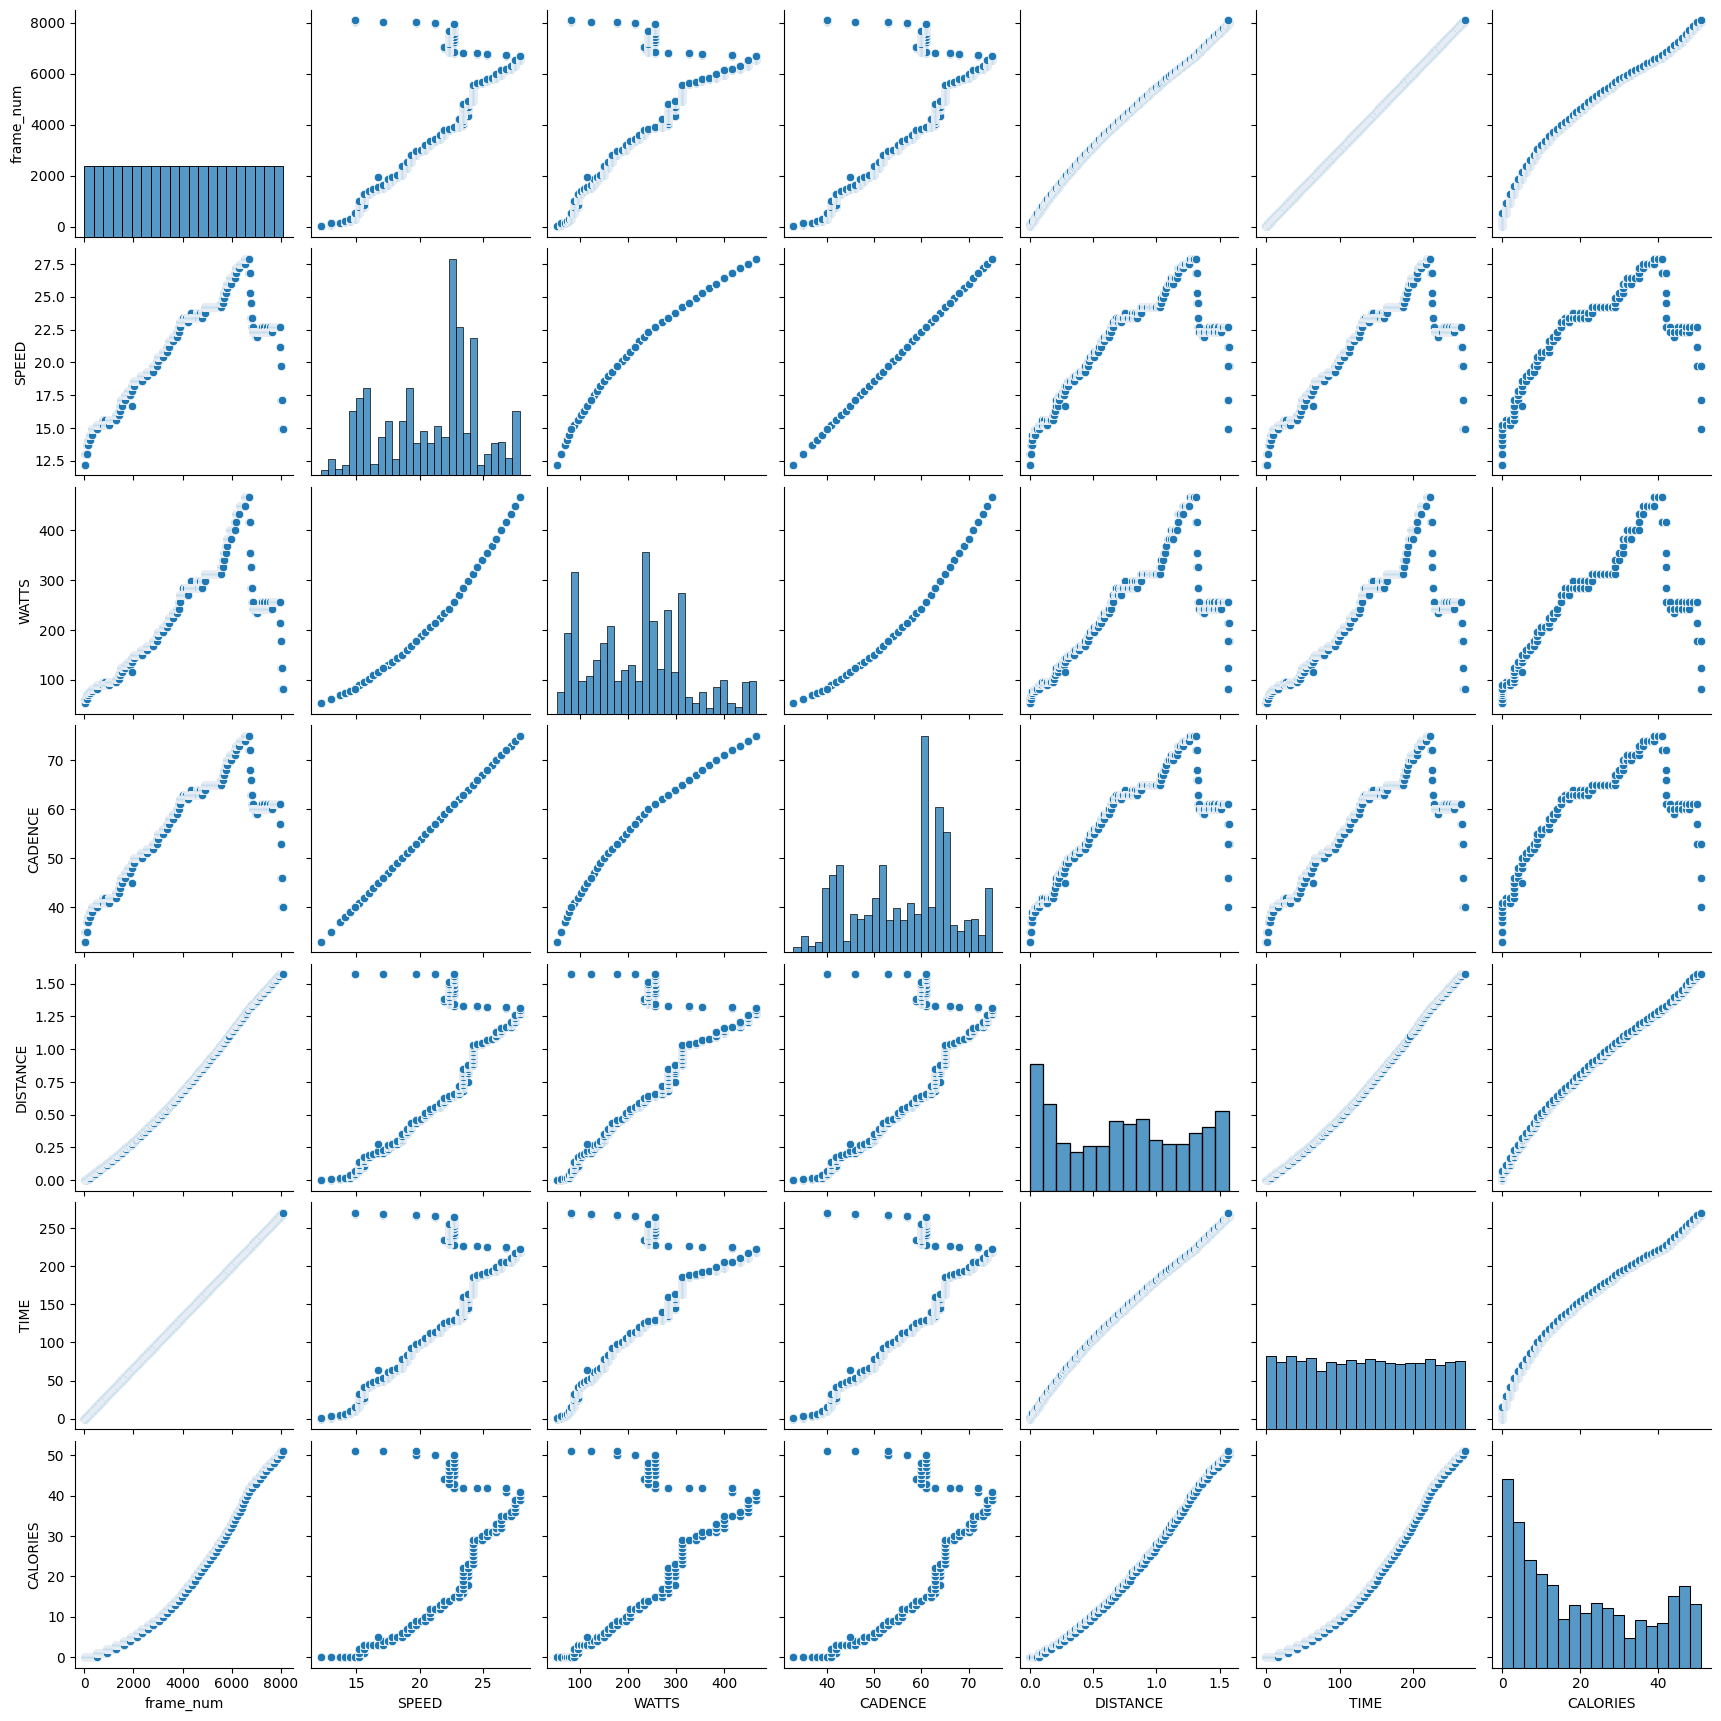

<IPython.core.display.Javascript object>

In [10]:
sns.pairplot(rogue_df)